# Proyek Machine Learning: Prediksi Cuaca
Proyek ini menggunakan dataset cuaca untuk memprediksi berbagai variabel cuaca.
Dataset yang digunakan adalah `kumpulan_data_prediksi_cuaca.csv` yang berisi data tentang cuaca.
Dalam notebook ini, kita akan melakukan tahapan dari import library, eksplorasi data, pemodelan, hingga evaluasi model.

# 1. Library Import

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # opsional untuk visualisasi tambahan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import kagglehub

In [2]:
!pip install tensorflow

**Insight**

*   Mengumpulkan semua import di satu cell membuat notebook lebih terstruktur dan memudahkan pengecekan dependensi di awal. Anda tidak perlu “bolak-balik” menambahkan import ketika menulis code di bagian lain.

# 2. Memuat dataset


In [3]:
path = kagglehub.dataset_download("thedevastator/weather-prediction")
df = pd.read_csv(path + "/weather_prediction_dataset.csv")
df.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


**Insight**


*   Dengan sekali panggil kagglehub.dataset_download dan pd.read_csv, Anda memastikan semua code terkait data loading terpusat—mempermudah debugging jika path atau otentikasi Kaggle bermasalah.

# 3. Data Preparation

## A. Cek missing values


In [4]:
print("Missing values per kolom:")
print(df.isnull().sum())

Missing values per kolom:
DATE                      0
MONTH                     0
BASEL_cloud_cover         0
BASEL_humidity            0
BASEL_pressure            0
                         ..
TOURS_global_radiation    0
TOURS_precipitation       0
TOURS_temp_mean           0
TOURS_temp_min            0
TOURS_temp_max            0
Length: 165, dtype: int64


**Insight**


*   Mengetahui kolom mana yang punya nilai hilang (missing) adalah dasar untuk memutuskan teknik imputasi atau drop—tanpa ini, model bisa menghasilkan hasil bias atau error saat fit.

## B. Cek duplikat


In [5]:
print(f"Jumlah duplikat: {df.duplicated().sum()}")

Jumlah duplikat: 0


**Insight**


*   Duplikat bisa “mengunci” model pada pola yang sama berulang-ulang, memperbesar risiko overfitting; mendeteksi dan menghapusnya menjaga keunikan sampel.

## C. Generate target & cek distribusi


In [27]:
df['rain_tomorrow'] = (df['BASEL_precipitation'].shift(-1) > 0).astype(int)
df = df.dropna(subset=['rain_tomorrow'])
print("Distribusi kelas target (rain_tomorrow):")
print(df['rain_tomorrow'].value_counts(normalize=True))

Distribusi kelas target (rain_tomorrow):
rain_tomorrow
0    0.533114
1    0.466886
Name: proportion, dtype: float64


**Insight**


*   Membuat target untuk klasifikasi disini saya memilih untuk prediksi apakah besok hujan atau tidak

# 4. Process Data


## A. Drop duplikat

In [7]:
df = df.drop_duplicates()

**Insight**


*   Setelah deteksi, menghapus baris duplikat sebelum analisis selanjutnya memastikan data “bersih” dan valid.

## B. Imputasi missing numeric & kategorikal


In [28]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.mean()))
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

**Insight**


*   Imputasi mean untuk numerik dan mode untuk kategorikal sederhana tapi efektif, menjaga distribusi asli data.

## C. Split Fitur & Label


In [29]:
X = df.drop(['rain_tomorrow', 'DATE'], axis=1)
y = df['rain_tomorrow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Insight**


*  Memisahkan data sebelum scaling atau modeling mencegah “data leakage” dan memastikan evaluasi yang jujur.

## D. Normalisasi (StandardScaler)


In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Insight**


*   Banyak algoritma (terutama neural network) sensitif pada skala fitur—standarisasi membuat semua fitur memiliki rata-rata 0 dan varians 1, mempercepat konvergensi.

# 5. Modeling

## A. Build model

In [33]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Insight**


*   Menyusun arsitektur (jumlah layer, neuron, activation) di awal memudahkan eksperimen hyperparameter dan dokumentasi.

## B. Train model



In [34]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6001 - loss: 0.6842 - val_accuracy: 0.6752 - val_loss: 0.6046
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6822 - loss: 0.5938 - val_accuracy: 0.6769 - val_loss: 0.6100
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6835 - loss: 0.5888 - val_accuracy: 0.6838 - val_loss: 0.5945
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7260 - loss: 0.5592 - val_accuracy: 0.6889 - val_loss: 0.5927
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7084 - loss: 0.5477 - val_accuracy: 0.6957 - val_loss: 0.5896
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6862 - loss: 0.5735 - val_accuracy: 0.6991 - val_loss: 0.5834
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7394 - loss: 0.5180 - val_accuracy: 0.7094 - val_loss: 0.5854
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7346 - loss: 0.5309 - val_accuracy: 0.7077 - val_lo

**Insight**


*   Memisahkan validation split membantu memantau overfitting di setiap epoch.

## C. Save model


In [35]:
model.save('weather_prediction_model.keras')

**Insight**


*   Menyimpan hasil training (.h5) memungkinkan reuse tanpa retraining ulang, bermanfaat untuk deployment atau analisis lanjutan.

# 6. Evaluasi

## A. Plot Loss

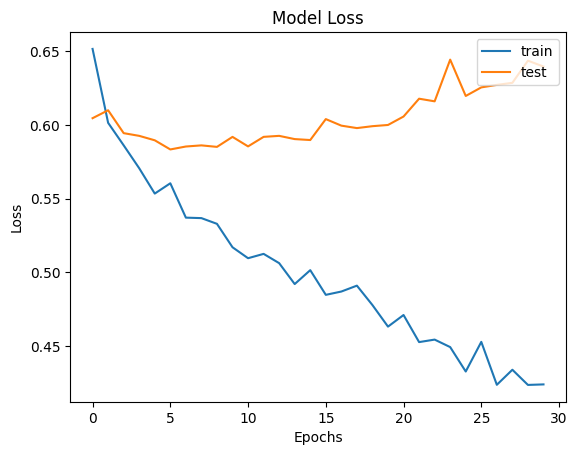

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Insight**


*   Dari data loss, kita dapat melihat bahwa model menunjukkan penurunan nilai loss yang konsisten pada data pelatihan (loss), yang menunjukkan bahwa model semakin baik dalam mempelajari pola dari data. Namun, pada data validasi (val_loss), meskipun ada sedikit penurunan di awal, nilai loss kemudian mulai meningkat pada epoch tertentu, yang menandakan adanya potensi overfitting, di mana model mulai belajar terlalu banyak detail yang spesifik untuk data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

## B. Plot Accuracy

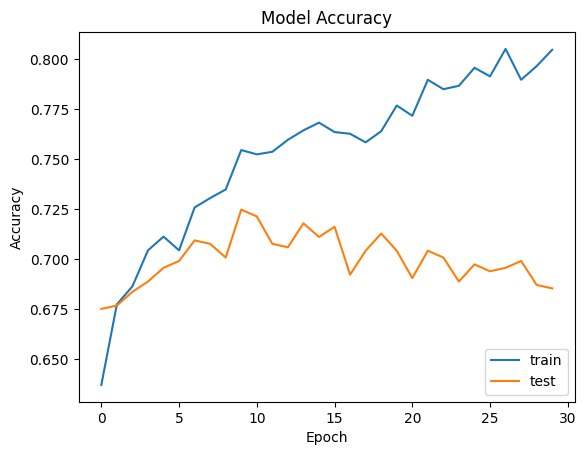

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

**Insight**


*   Untuk akurasi, kita dapat melihat bahwa model terus menunjukkan peningkatan yang stabil pada data pelatihan (accuracy) sepanjang pelatihan. Akurasi pada data pelatihan naik hingga mencapai lebih dari 80% pada epoch terakhir. Namun, pada data validasi (val_accuracy), meskipun ada peningkatan awal, akurasi tidak meningkat dengan signifikan setelah epoch ke-20. Hal ini menunjukkan bahwa meskipun model mampu mengklasifikasikan data pelatihan dengan baik, ia kesulitan untuk menjaga performa yang konsisten saat diuji dengan data yang tidak terlihat sebelumnya.

## **Insight dari kedua plot**

* Secara keseluruhan, meskipun model menunjukkan perkembangan yang positif dalam hal akurasi dan penurunan loss pada data pelatihan, peningkatan performa pada data validasi mulai menurun setelah beberapa epoch. Ini menunjukkan bahwa model mungkin mulai mengalami overfitting, di mana ia belajar terlalu banyak detail yang spesifik pada data pelatihan dan gagal menggeneralisasi dengan baik pada data baru. Idealnya, kita ingin melihat peningkatan yang lebih konsisten pada akurasi dan penurunan loss baik pada data pelatihan maupun data validasi.

## C. Report klasifikasi di test set

In [39]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[280 110]
 [119 222]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       390
           1       0.67      0.65      0.66       341

    accuracy                           0.69       731
   macro avg       0.69      0.68      0.68       731
weighted avg       0.69      0.69      0.69       731



**Insight**


*   Model ini menunjukkan akurasi 69%, yang menunjukkan bahwa secara keseluruhan, model cukup baik dalam memprediksi kelas. Namun, meskipun akurasi relatif tinggi, ada perbedaan kinerja antara kedua kelas yang diprediksi. Untuk kelas 0, model memiliki precision dan recall yang sedikit lebih baik (0.70 dan 0.72), menunjukkan bahwa model lebih sering memprediksi kelas ini dengan benar. Sebaliknya, untuk kelas 1, meskipun precision dan recall lebih rendah (0.67 dan 0.65), ini menunjukkan bahwa model kurang optimal dalam mengenali kelas ini. Dengan f1-score yang hampir setara di kedua kelas, model dapat dipertimbangkan cukup seimbang, meskipun ada ruang untuk perbaikan, terutama pada kelas 1.

## D. Confusion Matrix

Confusion Matrix (Numerik):
[[TN: 280  FP: 110]
 [FN: 119  TP: 222]]


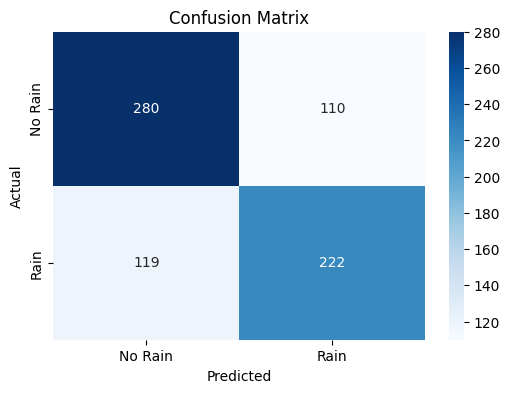

In [41]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Cetak matriks secara numerik
print("Confusion Matrix (Numerik):")
print(f"[[TN: {cm[0,0]}  FP: {cm[0,1]}]\n [FN: {cm[1,0]}  TP: {cm[1,1]}]]")

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'],
            cmap='Blues')

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Insight**


*   Model berhasil mengenali 280 hari yang memang tidak hujan dan 222 hari yang benar-benar hujan dengan tepat. Namun, model juga salah memprediksi 119 hari sebagai hujan padahal tidak (false alarm), dan melewatkan 110 hari hujan yang justru diprediksi tidak hujan. Artinya, model masih cukup sering gagal menangkap hari-hari yang seharusnya hujan, yang bisa jadi penting untuk peringatan cuaca.